In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score
from itertools import product
from scipy.sparse import coo_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.linalg import orthogonal_procrustes
from utils_plot import *

In [2]:
# 1. Data Normalization
def preprocessing(alpha1, alpha2, N, ampl_threshold=0.2):

    targetnames = np.array(sorted(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    #N_norm = N - np.mean(N, axis=0, keepdims=True) #We will optimize the sparse matrix, so we need to keep the absolute zero values.

    return alpha1_norm, alpha2_norm, N, targetnames_filtered, tf_names_filtered

In [3]:
# 2 Define Ridge Regression Model with Trainable Sparse W
class TrainableModel(nn.Module):
    def __init__(self, N, alpha, A_split, num_tfs, num_thetas, lambdaW=0.01, lambdaA=0.01):
        super(TrainableModel, self).__init__()
        
        self.lambdaW = lambdaW  # L1 regularization for W
        self.lambdaA = lambdaA  # L2 regularization for A

        # Convert N to COO format
        sparse_matrix = coo_matrix(N)

        # Get the nonzero indices and values
        self.i = torch.tensor(sparse_matrix.row, dtype=torch.long)
        self.j = torch.tensor(sparse_matrix.col, dtype=torch.long)
        values = torch.tensor(sparse_matrix.data, dtype=torch.float32)

        # Create W as a trainable vector for the non-zero elements of N
        #self.W = nn.Parameter(torch.randn(len(values)) * 0.05)
        self.W = nn.Parameter(values)

        # Initialize the unconstrained TF activity parameters
        #self.A = nn.Parameter(torch.randn(num_tfs, num_thetas) * 0.05)
        A_split = torch.tensor(A_split, dtype=torch.float32)
        self.A = nn.Parameter(A_split)

        self.num_genes, self.num_tfs = N.shape

    def forward(self):
        # Create a sparse tensor for W
        W_sparse = torch.sparse_coo_tensor(
            indices=torch.stack([self.i, self.j]), 
            values=self.W, 
            size=(self.num_genes, self.num_tfs)
        )
        W_dense_tensor = W_sparse.to_dense()

        # Compute the reconstructed alpha matrix.
        return torch.matmul(W_dense_tensor, self.A)

    def loss(self, alpha_true):
        alpha_pred = self.forward()
        main_loss = torch.sum((alpha_true - alpha_pred) ** 2)
        l1_loss = torch.sum(torch.abs(self.W))  # L1 on W
        l2_loss = torch.sum(self.A ** 2)         # L2 on the unconstrained A
        
        #smoothness_loss = 10*torch.sum((self.x[:, 1:] - self.x[:, :-1])**2) #Avoid spikes in A
        #cyclic_loss = torch.sum((self.x[:, 0] - self.x[:, -1])**2) #Make activities more cyclic
        #slope_loss = torch.sum((self.x[:, 1] - self.x[:, 0] - (self.x[:, -1] - self.x[:, -2]))**2) #Make slopes matc

        total_loss = main_loss + self.lambdaW * l1_loss + self.lambdaA * l2_loss
        return total_loss

In [4]:
def train_model(N, alpha, alpha_test, lambdaW, lambdaA, A_split, tol=0.04, patience=20, num_epochs=400, lr=0.005):
    # require 4% improvement every 20 epochs
    num_genes, num_tfs = N.shape
    num_thetas = alpha.shape[1]
    
    model = TrainableModel(N, alpha, A_split, num_tfs, num_thetas, lambdaW, lambdaA)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_EV = -float("inf")
    best_test_loss = float("inf")
    patience_counter = 0
    
    train_loss_history = []
    test_loss_history = []
    test_EV_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model.loss(alpha)
        loss.backward()
        optimizer.step()

       # Validation Step (keep computations in PyTorch)
        W_sparse_vector = model.W.detach()
        W_dense = torch.sparse_coo_tensor(
            indices=torch.stack([model.i, model.j]),
            values=W_sparse_vector,
            size=(num_genes, num_tfs)
        ).to_dense()
        A = model.A.detach()

        # Calculate R_test as a torch tensor
        R_test = torch.matmul(W_dense, A)

        # Calculate EV_test (convert tensors to NumPy for explained_variance_score)
        EV_test = explained_variance_score(alpha_test.numpy(), R_test.detach().numpy())

        # Calculate Test Loss in PyTorch
        main_loss = torch.sum((alpha_test - R_test) ** 2)
        l1_loss = torch.sum(torch.abs(W_sparse_vector))  # L1 on W
        l2_loss = torch.sum(A ** 2)                         # L2 on the unconstrained A
        total_test_loss = main_loss + lambdaW * l1_loss + lambdaA * l2_loss
        
        train_loss_history.append(loss.item())
        test_loss_history.append(total_test_loss)
        test_EV_history.append(EV_test)

        # Check for early stopping
        if total_test_loss < best_test_loss * (1 - tol) or total_test_loss < best_test_loss - 1000:
            best_EV = EV_test
            best_test_loss = total_test_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.0f}, Loss test: {total_test_loss:.0f}, EV_test: {EV_test*100:.2f}%")

        #if patience_counter >= patience:
        #    print(f"Early stopping at epoch {epoch+1}. Best Loss test: {best_test_loss:.0f}. Best EV_test: {best_EV*100:.2f}%")
        #    break
    
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss value')
    ax1.plot(range(epoch+1), train_loss_history, color='tab:red', label="Train Loss")
    ax1.plot(range(epoch+1), test_loss_history, color='tab:green', label="Test Loss")
    ax1.tick_params(axis='y')
    ax1.grid(True)
    ax1.legend(loc='center right')

    ax2 = ax1.twinx()
    ax2.set_ylabel('EV Test', color='tab:blue')
    ax2.plot(range(epoch+1), test_EV_history, color='tab:blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.suptitle('Loss and EV Over Epochs')
    fig.tight_layout()
    plt.show()

    return W_dense.numpy(), A.numpy(), loss.item()#, total_test_loss

In [5]:
# 4. Cross-Validation for Lambda Optimization
def cross_val_lambda(N, alpha1, alpha2, lambdaW_values, lambdaA_values):
    best_lambdaW, best_lambdaA, best_EV = None, None, -np.inf
    losses1 = []
    losses2 = []
    EVs_avg = []

    for lambdaW, lambdaA in product(lambdaW_values, lambdaA_values):
        print(f"Testing lambdaW = {lambdaW:.2f}, lambdaA = {lambdaA:.2f}")

        # Train on alpha1, test on alpha2
        W1, A1, loss1 = train_model(N, alpha1, alpha2, lambdaW, lambdaA, A_split)
        losses1.append(loss1)
        R_test1 = W1 @ A1
        EV1 = explained_variance_score(alpha2, R_test1)

        # Train on alpha2, test on alpha1
        W2, A2, loss2 = train_model(N, alpha2, alpha1, lambdaW, lambdaA, A_split)
        losses2.append(loss2)
        R_test2 = W2 @ A2
        EV2 = explained_variance_score(alpha1, R_test2)

        avg_EV = (EV1 + EV2) / 2
        EVs_avg.append(avg_EV)
        print(f"lambdaW={lambdaW:.2f}, lambdaA={lambdaA:.2f}, EV={avg_EV*100:.2f}%\n")

        if avg_EV > best_EV:
            best_lambdaW, best_lambdaA, best_EV = lambdaW, lambdaA, avg_EV
            
    EV_surface = np.array(EVs_avg).reshape(len(lambdaW_values), len(lambdaA_values))
    LambdaW, LambdaA = np.meshgrid(lambdaW_values, lambdaA_values, indexing='ij')

    # Find optimal point
    best_idx = np.unravel_index(np.argmax(EV_surface), EV_surface.shape)
    opt_lambdaW = lambdaW_values[best_idx[0]]
    opt_lambdaA = lambdaA_values[best_idx[1]]

    # Plot
    plt.figure(figsize=(7, 5))
    cp = plt.contourf(LambdaW, LambdaA, EV_surface, levels=30, cmap='viridis')
    plt.colorbar(cp, label='Average Explained Variance')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('λ_W (W regularization)')
    plt.ylabel('λ_A (A regularization)')
    plt.title('EV Surface over λ_W, λ_A')
    plt.scatter([opt_lambdaW], [opt_lambdaA], color='red', label='Optimum')
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Best λ_W = {best_lambdaW:.2f}, Best λ_A = {best_lambdaA:.2f}, Best EV = {best_EV*100:.2f}%\n")
    return best_lambdaW, best_lambdaA

In [6]:
# 5. Cross train for best model
def cross_train(N, alpha1, alpha2, best_lambdaW, best_lambdaA, A_split, tol=0.04, patience=20):
    print("Training on α1, testing on α2...")
    W1, A1, loss1 = train_model(N, alpha1, alpha2, best_lambdaW, best_lambdaA, A_split, tol, patience)
    R_test1 = W1 @ A1
    EV1_train = explained_variance_score(alpha1.numpy(), R_test1)
    EV1_test = explained_variance_score(alpha2.numpy(), R_test1)

    print("Training on α2, testing on α1...")
    W2, A2, loss2 = train_model(N, alpha2, alpha1, best_lambdaW, best_lambdaA, A_split, tol, patience)
    R_test2 = W2 @ A2
    EV2_train = explained_variance_score(alpha2.numpy(), R_test2)
    EV2_test = explained_variance_score(alpha1.numpy(), R_test2)

    avg_EV_train = (EV1_train + EV2_train) / 2
    avg_EV_test = (EV1_test + EV2_test) / 2
    print(f"Average EV_train: {avg_EV_train*100:.2f}%")
    print(f"Average EV_test: {avg_EV_test*100:.2f}%")
    
    return W1, A1, W2, A2

In [7]:
def standardize_amplitudes(matrices, target_amp=0.2):
    """
    Rescale the matrices to a single target amplitude.
    """
    standardized_matrices = []
    for matrix in matrices:
        amp = (np.max(matrix, axis=1) - np.min(matrix, axis=1)) / 2
        scale = target_amp / amp
        standardized_matrix = matrix * scale[:, np.newaxis]
        standardized_matrices.append(standardized_matrix)
    
    return standardized_matrices

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360) 

Tolerance : 0.05 Patience : 20
Training on α1, testing on α2...
Epoch 0, Loss: 21336, Loss test: 21326, EV_test: 9.58%
Epoch 100, Loss: 11494, Loss test: 13247, EV_test: 57.12%
Epoch 200, Loss: 7569, Loss test: 9567, EV_test: 60.56%
Epoch 300, Loss: 5688, Loss test: 7733, EV_test: 61.25%


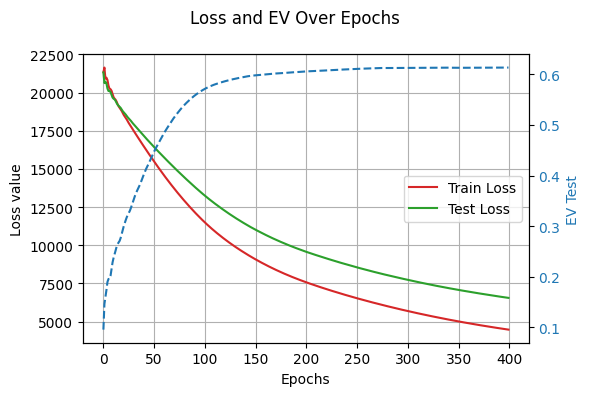

Training on α2, testing on α1...
Epoch 0, Loss: 20940, Loss test: 21648, EV_test: 11.14%
Epoch 100, Loss: 11375, Loss test: 13338, EV_test: 58.19%
Epoch 200, Loss: 7487, Loss test: 9627, EV_test: 61.21%
Epoch 300, Loss: 5630, Loss test: 7797, EV_test: 62.11%


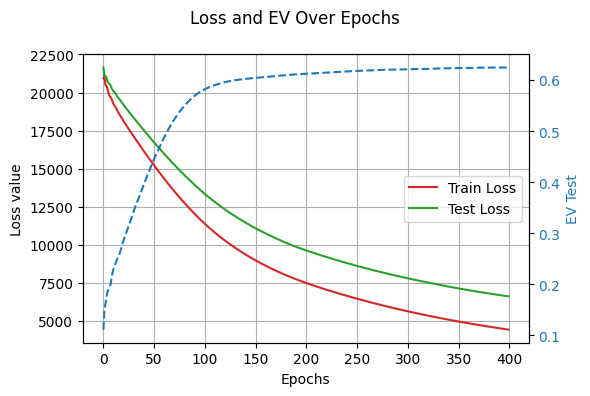

Average EV_train: 97.13%
Average EV_test: 61.88%


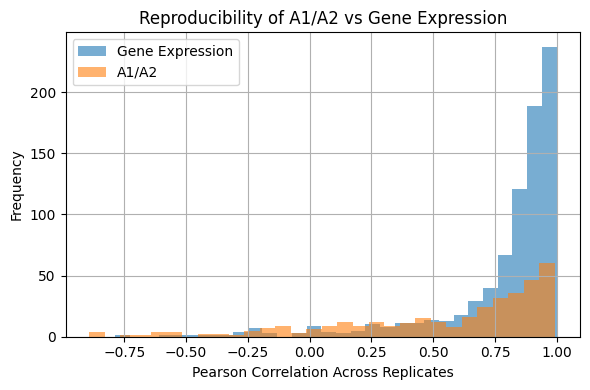

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of A1/A2:        0.552
Median correlation of A1/A2:      0.718


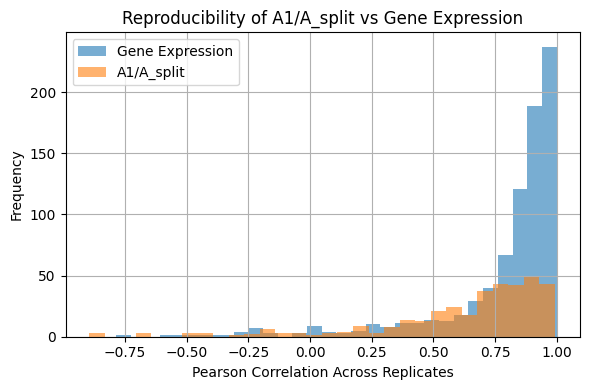

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of A1/A_split:        0.626
Median correlation of A1/A_split:      0.73


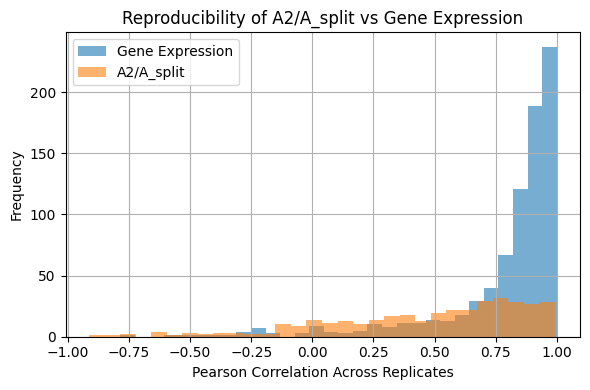

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of A2/A_split:        0.471
Median correlation of A2/A_split:      0.582


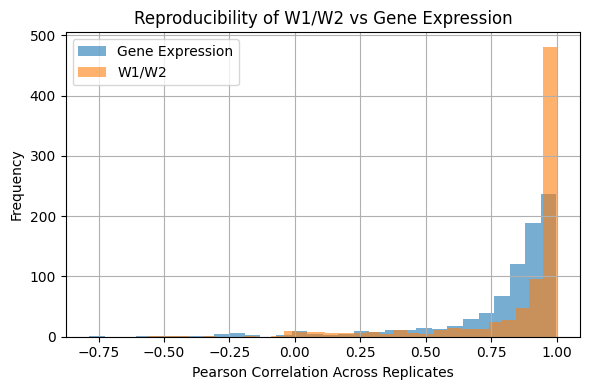

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of W1/W2:        0.854
Median correlation of W1/W2:      0.971


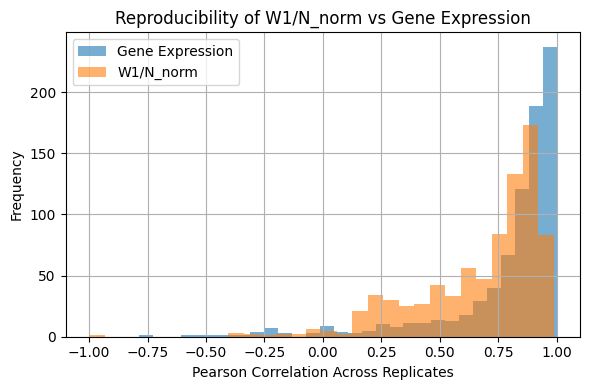

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of W1/N_norm:        0.676
Median correlation of W1/N_norm:      0.775


In [8]:
# Load Data & Run
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
torch.manual_seed(42)
ampl_threshold=0.2

# Define Lambda Values
#lambdaW_values = np.logspace(-1, 1, 10)
#lambdaA_values = np.logspace(-2, 0, 10)
#lambdaW_values = [0.89]
best_lambdaW, best_lambdaA = 0.77, 0.36

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)
A_split = np.load("activities_export/ampl_"+str(ampl_threshold)+"/A_star_split.npy")

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape, "\n")

n_tfs = A_split.shape[0]
n_genes = alpha1_norm.shape[0]

N_tensor = torch.tensor(N_norm, dtype=torch.float32)  # (genes, TFs)
alpha1_tensor = torch.tensor(alpha1_norm, dtype=torch.float32)  # (genes, thetas)
alpha2_tensor = torch.tensor(alpha2_norm, dtype=torch.float32)  # (genes, thetas)

# Optimize Lambda
#best_lambdaW, best_lambdaA = cross_val_lambda(N_tensor, alpha1_tensor, alpha2_tensor, lambdaW_values, lambdaA_values)
#for tol in np.linspace(0.01, 0.07, 7):
for tol in [0.05]:
    #for patience in np.linspace(5, 30, 7):
    for patience in [20]:
        # Train and Cross-Test
        print("Tolerance :", tol, "Patience :", patience)
        W1, A1, W2, A2 = cross_train(N_tensor, alpha1_tensor, alpha2_tensor, best_lambdaW, best_lambdaA, A_split, tol, patience)
        
        compute_reproducibility(A1, A2, alpha1_norm, alpha2_norm, metric="A1/A2")
        compute_reproducibility(A1, A_split, alpha1_norm, alpha2_norm, metric="A1/A_split")
        compute_reproducibility(A2, A_split, alpha1_norm, alpha2_norm, metric="A2/A_split")
        compute_reproducibility(W1, W2, alpha1_norm, alpha2_norm, metric="W1/W2")
        compute_reproducibility(W1, N_norm, alpha1_norm, alpha2_norm, metric="W1/N_norm")       

# Save activities (TFs × θ)
#np.save("activities_export/A_star_pytorch.npy", A1)
#np.save("activities_export/tf_names_pytorch.npy", np.array(tf_names))
#np.save("activities_export/targetnames_pytorch.npy", np.array(targetnames))

In [9]:
print(np.sort(W1.flatten()))
print(np.sort(A1.flatten()))

[-1.0026706  -0.74081796 -0.72329146 ... 16.857283   18.020456
 29.49404   ]
[-0.58422107 -0.58278817 -0.5812545  ...  0.6864196   0.68725586
  0.6916594 ]


In [10]:
#We smooth activities
A1 = fourier_fit(A1, theta_smooth)
A2 = fourier_fit(A2, theta_smooth)
R1 = W1 @ A1
R2 = W2 @ A2

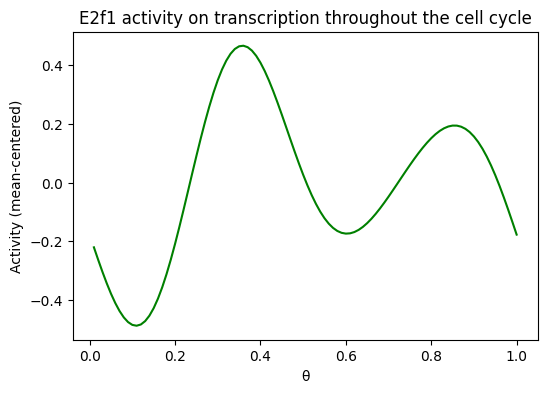

Positive W1 among target genes of E2f1 : 106/160 (66.25%)


In [11]:
BP_nb = np.where(tf_names == 'E2f1')[0][0]
#BP_nb = 30
plot_binding_protein_activity(tf_names, A1, process, theta_smooth, BP_nb=BP_nb)
print(f"Positive W1 among target genes of {tf_names[BP_nb]} : {np.sum(W1[:, BP_nb] > 0)}/{np.sum(W1[:, BP_nb] != 0)} ({np.sum(W1[:, BP_nb] > 0)/np.sum(W1[:, BP_nb] != 0)*100:.2f}%)")

Train


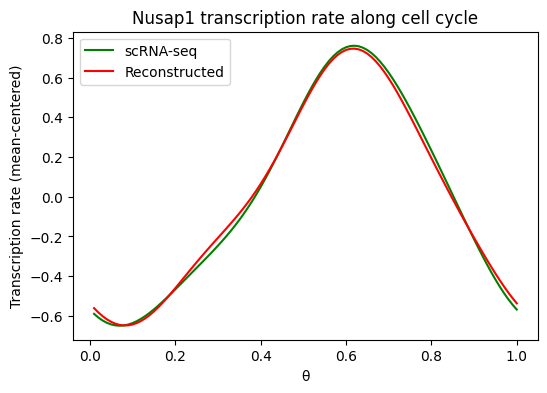

Test


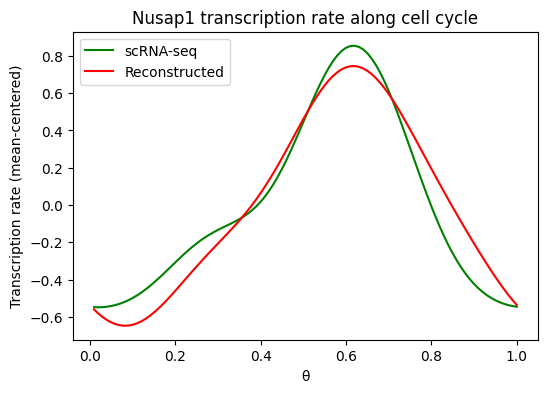

In [12]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 4972
print("Train")
plot_rate_comparison(targetnames, alpha1_norm, R1, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha2_norm, R1, process, theta_smooth, target_nb=n)

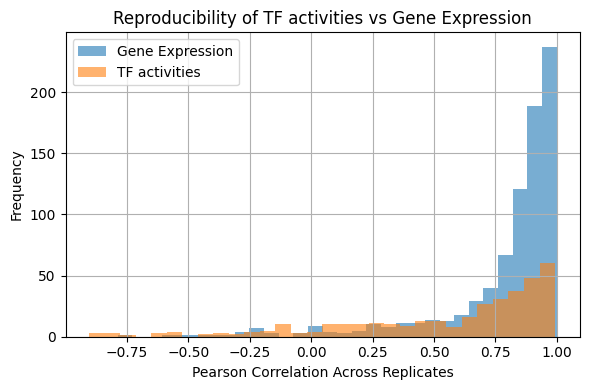

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of TF activities:        0.556
Median correlation of TF activities:      0.733


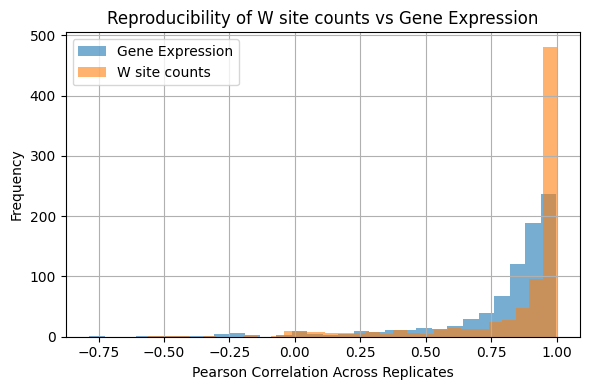

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of W site counts:        0.854
Median correlation of W site counts:      0.971


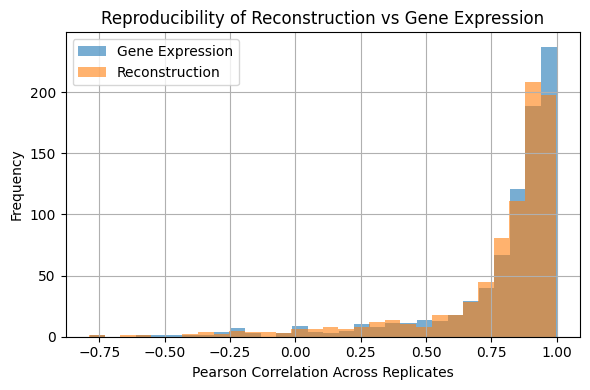

Mean correlation of expression profiles:  0.788
Median correlation of expression:         0.886
Mean correlation of Reconstruction:        0.771
Median correlation of Reconstruction:      0.878


In [13]:
compute_reproducibility(A1, A2, alpha1_norm, alpha2_norm, metric="TF activities")
compute_reproducibility(W1, W2, alpha1_norm, alpha2_norm, metric="W site counts")
compute_reproducibility(R1, R2, alpha1_norm, alpha2_norm, metric="Reconstruction")

['Smad3' 'Sp1' 'Tfap4' 'E2f1' 'E2f8' 'E2f2_E2f5' 'Elf3' 'E2f4' 'Hbp1'
 'E2f7' 'Hes1' 'E2f3' 'E2f6']


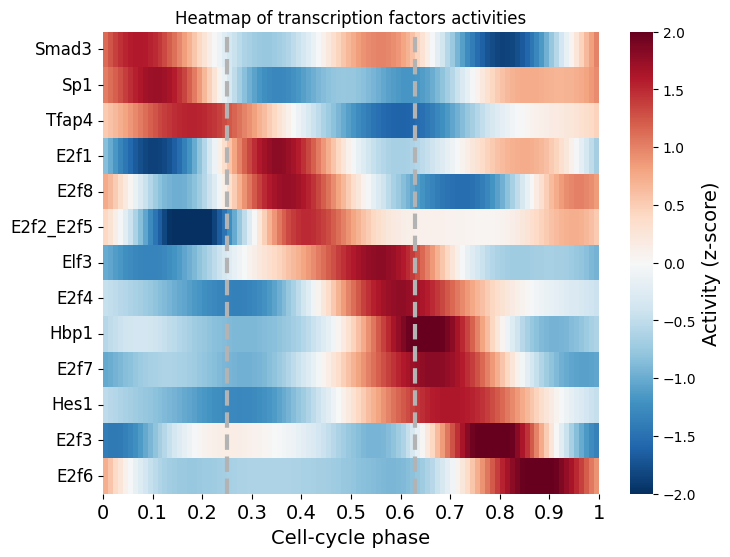

In [14]:
#Heatmap of BPs activity along cell cycle (Export)
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2_E2f5", "E2f3", "E2f4", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1", "Elf3", "Tfap4"]
tf_displayed = plot_heatmap_list(A1, tf_names, key_tfs, clip=True)
print(tf_displayed)

In [15]:
expected_activity = {
    "Smad3": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "Hbp1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "E2f1": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f2_E2f5": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f3": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f4": {"ranges": [(0.01, 0.25)], "inhibitory": False}, #May be True
    "E2f6": {"ranges": [(0.01, 0.25), (0.63, 0.9)], "inhibitory": False}, #May be True
    "E2f7": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "E2f8": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "Sp1": {"ranges": [(0.1, 0.63)], "inhibitory": False},
    "Hes1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    #"Elf3": {"ranges": [(0.25, 1)], "inhibitory": False},
    #"Tfap4": {"ranges": [(0.63, 0.9)], "inhibitory": False}
}

In [16]:
#### TF EXPRESSION AND BIOLOGICAL MEANING ####

In [17]:
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2", "E2f3", "E2f4", "E2f5", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1"]

fileAlphaTF_sn1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlphaTF_sn2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"

#Get spliced RNA data to compare splicing and protein activity dynamics
alpha_sn1 = pd.read_csv(fileAlphaTF_sn1, sep=",",index_col=0)
alpha_sn2 = pd.read_csv(fileAlphaTF_sn2, sep=",",index_col=0)

tf_names_filtered = np.array([tf for tf in key_tfs if tf in alpha_sn1.index and tf in alpha_sn2.index and tf in tf_names])
print("TFs in common :", str(len(tf_names_filtered))+"/"+str(len(key_tfs)))

alpha_sn1_f, alpha_sn2_f = alpha_sn1.loc[tf_names_filtered], alpha_sn2.loc[tf_names_filtered]
alpha_sn1_n, alpha_sn2_n = alpha_sn1_f.to_numpy(), alpha_sn2_f.to_numpy()

#Standardize amplitudes
#A_standard = A_standard - np.mean(A_standard, axis=1, keepdims=True)
alpha_sn_n = (alpha_sn1_n + alpha_sn2_n) / 2
alpha_sn_norm = alpha_sn_n - np.mean(alpha_sn_n, axis=1, keepdims=True) - np.mean(alpha_sn_n, axis=0, keepdims=True) + np.mean(alpha_sn_n)
alpha_sn_norm, A_standard = standardize_amplitudes([alpha_sn_norm, A1])

TFs in common : 10/12


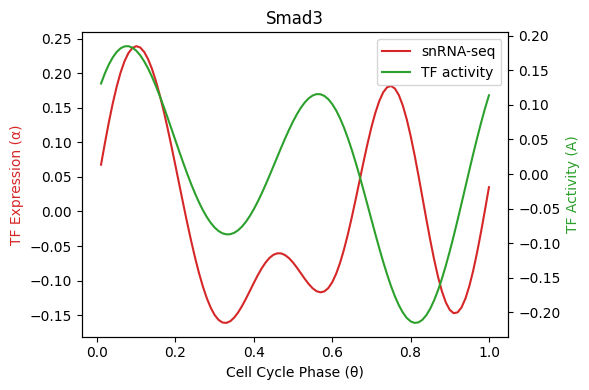

scRNA & A correlation : -0.303 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -3.00 (inhibitor)


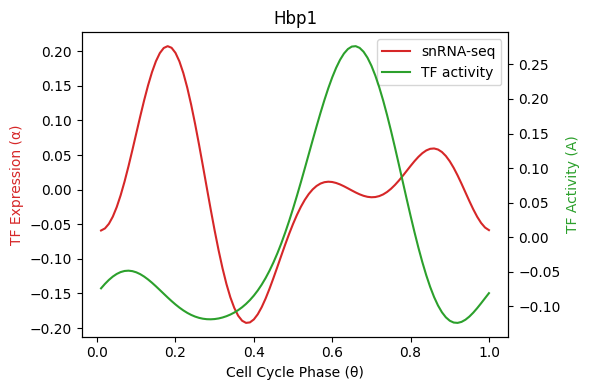

scRNA & A correlation : 0.033 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 8.17 (inhibitor)


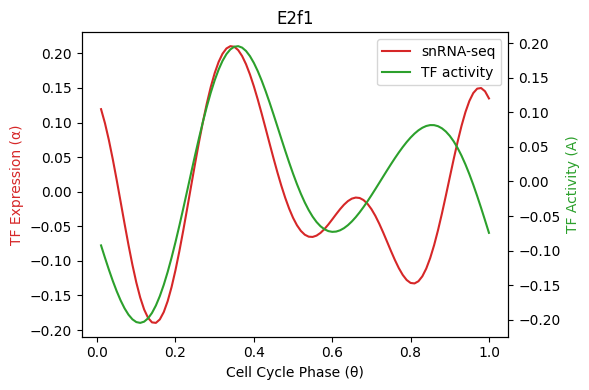

scRNA & A correlation : 0.523 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 0.19 (activator)


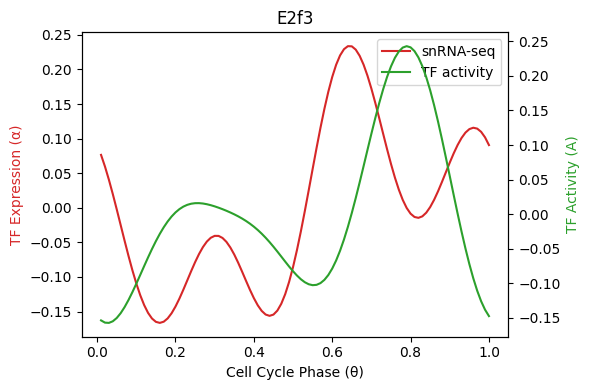

scRNA & A correlation : 0.067 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -4.87 (activator)


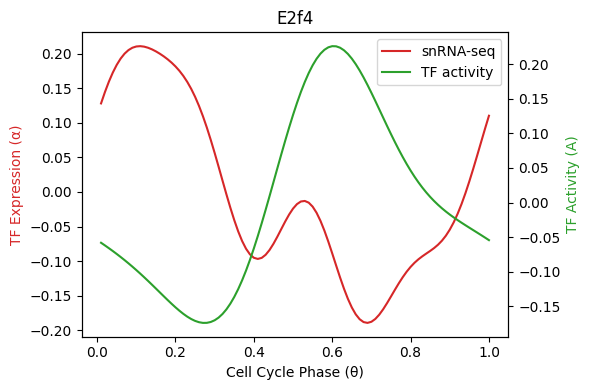

scRNA & A correlation : -0.708 (activator)

Expected activity range : [(0.01, 0.25)]
TF activity biological z-score : -9.67 (activator)


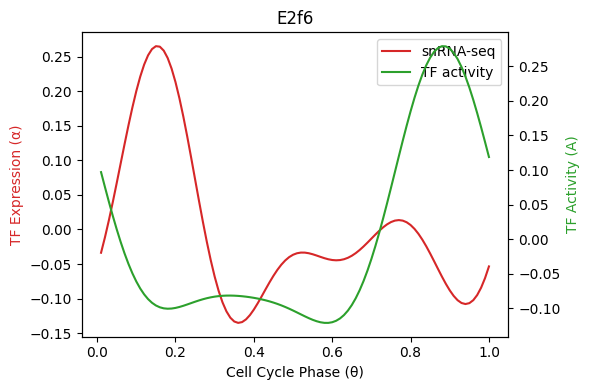

scRNA & A correlation : -0.145 (activator)

Expected activity range : [(0.01, 0.25), (0.63, 0.9)]
TF activity biological z-score : 2.42 (activator)


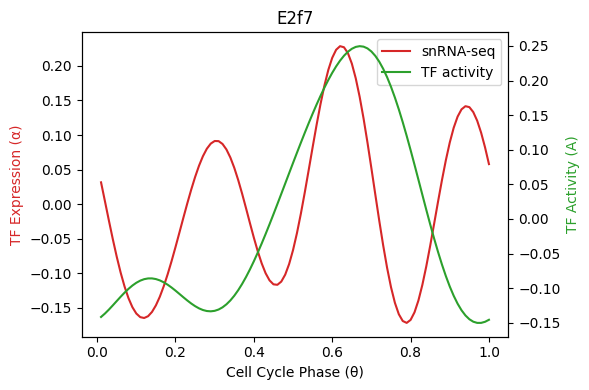

scRNA & A correlation : -0.043 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 14.60 (activator)


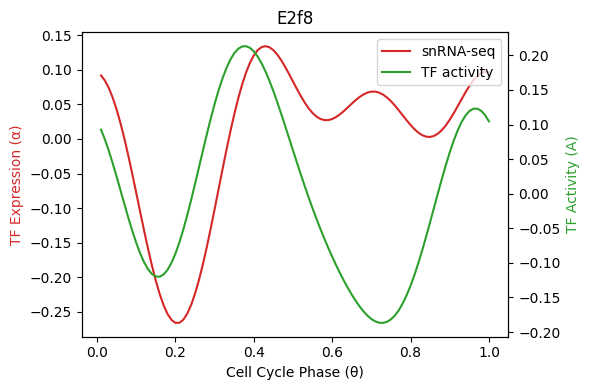

scRNA & A correlation : 0.353 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : -3.82 (activator)


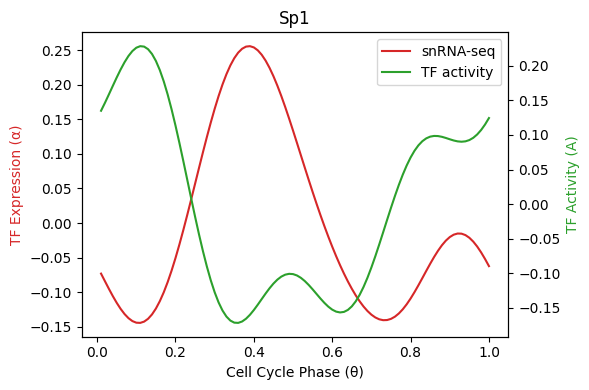

scRNA & A correlation : -0.622 (activator)

Expected activity range : [(0.1, 0.63)]
TF activity biological z-score : -4.64 (activator)


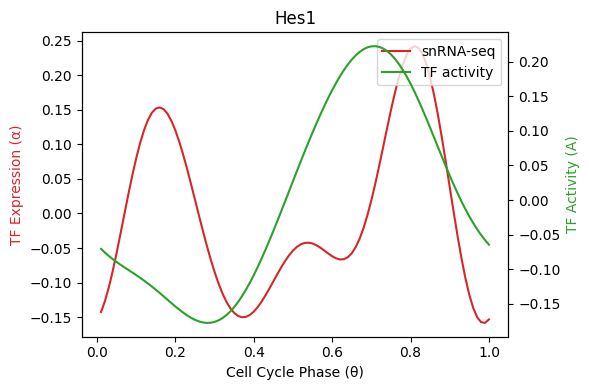

scRNA & A correlation : -0.260 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 19.95 (inhibitor)
Global correlation :-0.110
Global z-score :1.93


In [18]:
corrs = []
z_vals = []
for tf in range(len(tf_names_filtered)):
    plot_TF_exp_activity(theta_smooth, alpha_sn_norm, A_standard, tf_names, tf_names_filtered, tf)
    corr = spearmanr(alpha_sn_norm[tf], A_standard[list(tf_names).index(tf_names_filtered[tf])])[0]
    action = "activator" if not expected_activity[tf_names_filtered[tf]]["inhibitory"] else "inhibitor"
    if (action == "inhibitor"):
        corr = -corr
    print(f"scRNA & A correlation : {corr:.3f} ({ action })\n")
    z_val = compute_tf_activity_difference(A_standard[list(tf_names).index(tf_names_filtered[tf]), :], theta_smooth, expected_activity[tf_names_filtered[tf]]["ranges"], expected_activity[tf_names_filtered[tf]]["inhibitory"])
    corrs.append(corr)
    z_vals.append(z_val)
    print(f"Expected activity range : {expected_activity[tf_names_filtered[tf]]["ranges"]}")
    print(f"TF activity biological z-score : {z_val:.2f} ({ action })")
print(f"Global correlation :{np.mean(corrs):.3f}")
print(f"Global z-score :{np.mean(z_vals):.2f}")